In [4]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Import the necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Word2Vec API
from gensim.models import Word2Vec

from IPython.display import display
from keras.preprocessing.text import Tokenizer

# Model preprocessing APIs
from sklearn import preprocessing
from sklearn.utils import resample

# Model accuracy plotting APIs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

# Model building APIs
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [6]:
# Set path variables

project_path = '/content/drive/My Drive/Colab/'
file_name ='TempOutput_1.xlsx'

In [7]:
# Import the dataframe

df_to_process=pd.read_excel(project_path + file_name)
df_to_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         7909 non-null   int64 
 1   Short description  7909 non-null   object
 2   Description        7906 non-null   object
 3   Assignment group   7909 non-null   object
 4   New Description    7876 non-null   object
 5   Language           7909 non-null   object
 6   Lemmatized clean   7909 non-null   object
dtypes: int64(1), object(6)
memory usage: 432.6+ KB


In [8]:
# Drop columns not needed for Model building

df_to_process.drop(["Unnamed: 0","Short description", "Description", "Language"],axis=1,inplace=True)

In [9]:
df_to_process.head(5)

,Assignment group,New Description,Lemmatized clean
0,GRP_0,login issue verified user details employee man...,"['login', 'issue', 'verify', 'user', 'detail',..."
1,GRP_0,outlook received from hmjdrvpb komuaywn team m...,"['outlook', 'receive', 'hmjdrvpb', 'komuaywn',..."
2,GRP_0,cannot log in to vpn received from eylqgodm yb...,"['log', 'vpn', 'receive', 'eylqgodm', 'ybqkwia..."
3,GRP_0,unable to access hr tool page unable to access...,"['unable', 'access', 'hr', 'tool', 'page', 'un..."
4,GRP_0,skype error skype error,"['skype', 'error', 'skype', 'error']"


In [10]:
df_to_process = df_to_process.dropna(axis=0)

In [11]:
# Label encode the assignment groups

label_encoder = preprocessing.LabelEncoder() 
  
df_to_process['Assignment group ID']= label_encoder.fit_transform(df_to_process['Assignment group']) 
df_to_process['Assignment group ID'].unique()

array([ 0,  1, 23, 34, 45, 56, 67, 72, 73,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28,
       29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48,
       49, 50, 51, 43, 52, 53, 54, 55, 57, 58, 26, 59, 60, 61, 62, 63, 64,
       65, 66, 68, 69, 70, 71])

In [12]:
# Function to generate word tokens

def wordTokenizer(dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe

In [13]:
# Word2Vec the dataframe and store the embedding result

sentences = [line.split(' ') for line in df_to_process['New Description']] 
word2vec = Word2Vec(sentences=sentences,min_count=1)
word2vec.wv.save_word2vec_format(project_path+'word2vec.txt')

In [14]:
# Load the embedding into memory

embedding_indices = dict()
f = open(project_path+'word2vec.txt')

for line in f:
  values = line.split()
  word = values[0]
  coeff = np.array(values[1:], dtype='float32')
  embedding_indices[word] = coeff
f.close()

len(embedding_indices)

15389

In [15]:
results = pd.DataFrame()
predictedResults = pd.DataFrame()

In [16]:
max_len = 300
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(df_to_process["New Description"].values)
X_seq = tokenizer.texts_to_sequences(df_to_process["New Description"].values)
X_padded = pad_sequences(X_seq, maxlen=max_len)

In [17]:
numWords = len(tokenizer.word_index) + 1
epochs = 10
batch_size=100
numWords

15389

In [18]:
# Try the BiLSTM model on the raw or unsampled data and predict the accuracy.

# Tokenize
tokenizer, X = wordTokenizer(df_to_process['New Description'])
y = np.asarray(df_to_process['Assignment group ID'])
X = pad_sequences(X,maxlen=max_len)

In [19]:
# Create embedding matrix

embedding_matrix = np.zeros((numWords+1,100))

for i,word in tokenizer.index_word.items():
  if i<numWords+1:
    embedding_vector = embedding_indices.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34595269, -0.82772446, -0.88963568, ..., -0.73123723,
         0.4247953 ,  0.51067954],
       [-0.37731153,  0.01297032, -0.4810777 , ...,  0.06237094,
        -0.47493449,  0.45205283],
       ...,
       [ 0.00470336,  0.0027298 , -0.00415757, ..., -0.01238738,
        -0.00663385,  0.00763759],
       [ 0.00969864,  0.003274  , -0.0072833 , ..., -0.02107823,
        -0.00313074,  0.01483126],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [23]:
# Perform the train-test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
X_train,X_test,y_train,y_test

(array([[   0,    0,    0, ...,    9,   36,  157],
        [   0,    0,    0, ...,   65,    1,  128],
        [   0,    0,    0, ...,  213, 6266, 4920],
        ...,
        [   0,    0,    0, ...,  330,  360,  132],
        [   0,    0,    0, ..., 1905,    3,   88],
        [   0,    0,    0, ...,   67,  911,  191]], dtype=int32),
 array([[   0,    0,    0, ...,    2,   33,  132],
        [   0,    0,    0, ..., 2380, 3373, 3374],
        [   0,    0,    0, ...,   56,  539,  132],
        ...,
        [   0,    0,    0, ...,   23,   34,  558],
        [   0,    0,    0, ...,   29,   23,   34],
        [   0,    0,    0, ...,  470,  491, 2941]], dtype=int32),
 array([23,  0,  0, ...,  0,  0, 55]),
 array([ 0,  4, 11, ..., 12,  0, 36]))

In [24]:
# Build the Bi-LSTM model

input_layer = Input(shape=(max_len,),dtype=tf.int64)
embed = Embedding(numWords+1,output_dim=100,input_length=max_len,weights=[embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
lstm=Bidirectional(LSTM(128))(embed)
drop=Dropout(0.3)(lstm)
dense =Dense(100,activation='relu')(drop)
out=Dense((len((pd.Series(y_train)).unique()) + 1),activation='softmax')(dense)   

model = Model(input_layer,out)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

model.summary()
plot_model(model,to_file=project_path + "Bi-LSTM(Word2Vec)_Unsampled_Model.jpg")

checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 100)          1539000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_3 (Dense)              (None, 74)                7474      
Total params: 1,806,670
Trainable params: 1,806,670
Non-trainable params: 0
____________________________________________

In [25]:
model_history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_test,y_test))

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.5909 - accuracy: 0.4917
Epoch 00001: val_accuracy improved from -inf to 0.54188, saving model to model-001-0.541878.h5
63/63 [==============================] - 108s 2s/step - loss: 2.5909 - accuracy: 0.4917 - val_loss: 2.0599 - val_accuracy: 0.5419
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 2.0268 - accuracy: 0.5437
Epoch 00002: val_accuracy improved from 0.54188 to 0.55266, saving model to model-002-0.552665.h5
63/63 [==============================] - 108s 2s/step - loss: 2.0268 - accuracy: 0.5437 - val_loss: 1.9217 - val_accuracy: 0.5527
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 1.8848 - accuracy: 0.5552
Epoch 00003: val_accuracy improved from 0.55266 to 0.56091, saving model to model-003-0.560914.h5
63/63 [==============================] - 107s 2s/step - loss: 1.8848 - accuracy: 0.5552 - val_loss: 1.8287 - val_accuracy: 0.5609
Epoch 4/10
63/63 [===================

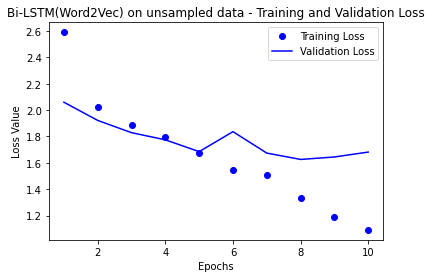

In [26]:
# Plot model losses

loss_values = model_history.history['loss']
val_loss_values = model_history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label="Training Loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")

plt.title('Bi-LSTM(Word2Vec) on unsampled data - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

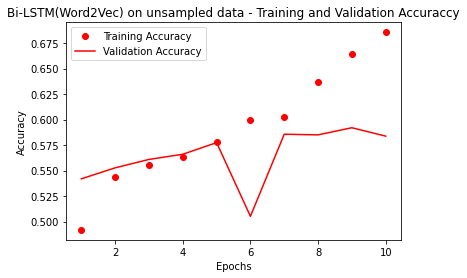

In [27]:
# Plot training and validation accuracies

acc_values = model_history.history['accuracy']
val_acc_values = model_history.history['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'ro', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")

plt.title('Bi-LSTM(Word2Vec) on unsampled data - Training and Validation Accuraccy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
# Summarize the model history

model_df = pd.DataFrame(model_history.history)
model_df

,loss,accuracy,val_loss,val_accuracy,lr
0,2.590919,0.491746,2.059931,0.541878,0.001
1,2.026844,0.543651,1.921705,0.552665,0.001
2,1.884818,0.555238,1.828696,0.560914,0.001
3,1.793860,0.563175,1.774456,0.565990,0.001
4,1.677173,0.578413,1.684860,0.577411,0.001
5,1.546688,0.599841,1.836435,0.505076,0.001
6,1.505949,0.602063,1.673810,0.585660,0.001
7,1.329751,0.637143,1.625634,0.585025,0.001
8,1.186250,0.664127,1.644304,0.592005,0.001
9,1.090733,0.685714,1.681478,0.583756,0.001


In [ ]:
# Thank you